<h1 class="heading"> Maneuver Test</h1>
<h1>Waypoint based, automatic guidance 1</h1>

<h6 class="author"> — <b style="color:rgb(0,51,102);">Carmine Varriale, Agostino De Marco</b>, <i>University of Naples Federico II</i></h6>

## Introduction and setup

In this Notebook, we are explaining how waypoint based navigation is scripted in JSBSim. Within this type of simulations, the aircraft is commanded to explicitly hold a heading or to head towards a specific location (a waypoint), whose coordinates have been input in terms of latitude and longitude. <br><br>

Please be aware that, in this phase, we are only and exclusively concerned with a 2D route desgin, i.e. the desgin of the ground track. We are in no way ready to control altitude yet: this will be the objective of another Notebook, in which we will try to develop an autopilot for controlling the flight path angle, both with throttle and elevator.<br><br>

As for now, let's gather the utilities we will need

In [1]:
% run ./python/nb_init.py                        
% matplotlib inline                             

import data_handling as dh
from ACDataPlots import ACDataPlots

HTML(open('./style/style_unina_iwes.css', 'r').read())

and setup the list of external files we are going to use throughout the Notebook.

In [4]:
# Directory house-keeping
dest_folder='../output/mantest_waypoint_auto_guidance/'

# Catalog to file
os.system('../JSBSim/JSBSim --root=../JSBSim/ --catalog=c172x_unina > ../JSBSim/catalog_c172x.txt')

# Reference to script file
script_path='../JSBSim/scripts/c172x_mantest_waypoint_auto_guidance.xml'

# Reference to initialization file
init_path = '../JSBSim/aircraft/c172x_unina/init_mantest_waypoint_auto_guidance.xml'

## Script analysis

In the initialization file, we are setting the aircraft up in straight and level conditions, as we have done in other simulations, but this time, since waypoint navigation is involved, precision on position must be necessarily stressed. With the aid of Google Maps, it is possible to easily get latitude and longitude of whatever location on Earth, with a precision up to $10^{-6} \mathrm{\,deg}$. <br><br>

Our simulation begins in Naples, Italy, and precisely over St. Elmo castle.
<br>
![](images/capture_castel_sant_elmo.png "Initialization over St. Elmo castle, in Naples")
<br>
Here is the complete initialization file: note the precision of latitude and longitude coordinates.

In [5]:
dh.show_file(init_path)

   1| <?xml version="1.0"?>                                       
   2| 
   3| <!-- 
   4| Set the aircraft initial condition
   5| at 1000 feet above Sea Level, 
   6| over Naples, and precisely St. Elmo castle
   7| on a heading of -5 degrees,
   8| on a horizontal flight path,
   9| with engine running.
  10| -->
  11| 
  12| <initialize name="EngineRunning">
  13| 
  14|     <vt unit="KTS">        100.0        </vt>
  15|     <latitude unit="DEG">   40.843874   </latitude>
  16|     <longitude unit="DEG">  14.239150   </longitude>
  17|     <psi unit="DEG">        -5.0        </psi>
  18|     <altitude unit="FT">  1000.0        </altitude>
  19|     <gamma unit="DEG">       0.0        </gamma>
  20|     <phi unit="DEG">         0.0        </phi>
  21|     <running>                0          </running>                                 
  22| 
  23| </initialize>

As long as the script is concerned, we must now take a closer look to the sequence of commands needed to perform automatic waypoint navigation:

* <div class="typewr">Event - Trim: </div> as soon as the simulation starts, we are trimming the aircraft in the specified initial conditions and performing a series of variables initialization:
    - The <div class="typewr">ap/pitch_setpoint</div> property is assigned the current value of the Euler angle $\theta$; this property is the reference value for the pitch hold autopilot, that will be switched on later.
    - The <div class="typewr">ap/heading_setpoint</div> property is manually set to the initial value of the heading (the same as the initialization file). This property represents the reference value for the heading hold autopilot, that will be switched on in the next event as well.
    - Finally, the <div class="typewr">ap/active-waypoint</div> property is set to $0$. This is just a flag property, which can assume any value we want, and is used to assign a label to the waypoint we are moving towards to. In this case, we are initially just following a route whose heading is $\psi = -5°$, so we are not using waypoints to navigate. Thus the property value is now $0$.
   
* <div class="typewr">Event - Heading Hold: </div> this event takes place at the same time of the previous one, but has been separated from it for it has a different function. Now, we are actually switching our autopilot systems on:
    - The <div class="typewr">ap/heading-setpoint-select</div> property is a mode selector for the heading hold autopilot: if its value is set to $0$, the autopilot will be in _Heading Mode_, if its value is set to $1$ it will work in _Waypoint Mode_. Therefore, it must be specified before switching the autopilot on and, of course, when changing guidance mode.
    - By switching the properties' <div class="typewr">ap/heading_hold</div> and <div class="typewr">ap/pitch_hold</div> values to $1$ we are finally switching the autopilots on for both Flight Control Systems channels. The will try, from now on, to pursue the reference values assigned before.
    
* <div class="typewr">Event - To Waypoint 1: </div> after 10 seconds of undisturbed navigation, during which our aircraft has used the heading autopilot to follow the initial route, we decide it's time to head towards our first waypoint. First, its location is specified in terms of latitude and longitude (expressed in radians) and then, the autopilot working mode is switched to _Waypoint Mode_ by means of the property <div class="typewr">ap/heading-setpoint-select</div>. At this point, the aircrfat should start a turn and head towards the newly input target. To keep track of the fact that we are moving towards the first waypoint, we also set a new value to the <div class="typewr">ap/active-waypoint</div> flag: though it does absolutely nothing at aircraft system level, it will be useful for triggering the next event.
<br>
Our first waypoint is set over the Capodimonte museum, which is aligned with the Capodichino airport landing field.
![](images/capture_museo_capodimonte.png "First waypoint over Capodimonte Museum, in Naples")

* <div class="typewr">Event - To Waypoint 2: </div> this event is triggered by the concurrence of two conditions: distance to waypoint is less then a threshold and waypoint has a specific label attached to it. What we are actually telling JSBSim is: _"If the aircraft is actually flying towards Waypoint 1, and the distance from it is less then 10 feet, then execute this event"_. The event body is relatively easy to understand, as it simply sets a new waypoint by means of inserting its latitude and longitude in radians. There is no need to set the autopilot up again, as it will endure in the same operating mode it already is in.

* <div class="typewr">Event - Descent: </div> this event is triggered at the same time of the previous one, but its actions happen with a $10$ seconds delay with respect to the triggering instant. We decided not to use the altitude autopilot in this case as it drives the aircraft to pitch down, resulting more in a dive than a descent for approach. Consequently, we here start the descending maneuver towards the Capodichino landing field (i.e. Waypoint $2$), by manually
    - setting our flaps in landing configuration;
    - decreasing the throttle;
    - pitching the aircraft up, by changing the reference value for the pitch autopilot;
    - changing the active waypoint flag property, since all operations due to happen over waypoint $1$ are compelted.
    
* <div class="typewr">Event - Landing: </div> finally, once close to the head of the landing field, we first update the heading to be held according to the orientation of the field (in this case, $\mathrm{QFU}\, 06/24$), we revert the autopilot back to _Heading mode_,  and set the waypoint flag to $0$.


<br><br>
Here you can see the location of the second and last waypoint, while the full script is reported below for analysis.
<br>
![](images/capture_pista_capodichino_06.png "First waypoint over Capodimonte Museum, in Naples")

In [6]:
dh.show_file(script_path)

   1| <?xml version="1.0"?>
   2| <?xml-stylesheet type="text/xsl" 
   3| 	href="http://jsbsim.sourceforge.net/JSBSimScript.xsl"?>
   4| 
   5| 
   6| <runscript xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
   7| 		xsi:noNamespaceSchemaLocation="http://jsbsim.sf.net/JSBSimScript.xsd"
   8| 		name="Script for C172x - Waypoint navigation test ">
   9| 
  10| 
  11|     <!--
  12| 		C172x performing some maneuvers for testing
  13|         waypoint base navigation
  14|     -->
  15| 
  16|     <use aircraft="c172x_unina" initialize="init_mantest_waypoint_auto_guidance" />
  17|     <run start="0.0" end="250" dt="0.0083333"> 
  18| 
  19| 
  20|         <!-- Trim in intial conditions -->
  21| 
  22|         <event name="Trim">
  23|             <description>Trim the aircraft in the initial conditions</description>
  24|             <condition> simulation/sim-time-sec ge 0 </condition>
  25|             <set name="simulation/do_simple_trim" value="1" />
  26|             <set nam

## Simulation launch

As always, here are the results of the simulation. From the log file, it is confirmed that all events have been triggered and that the simulation has been successful.

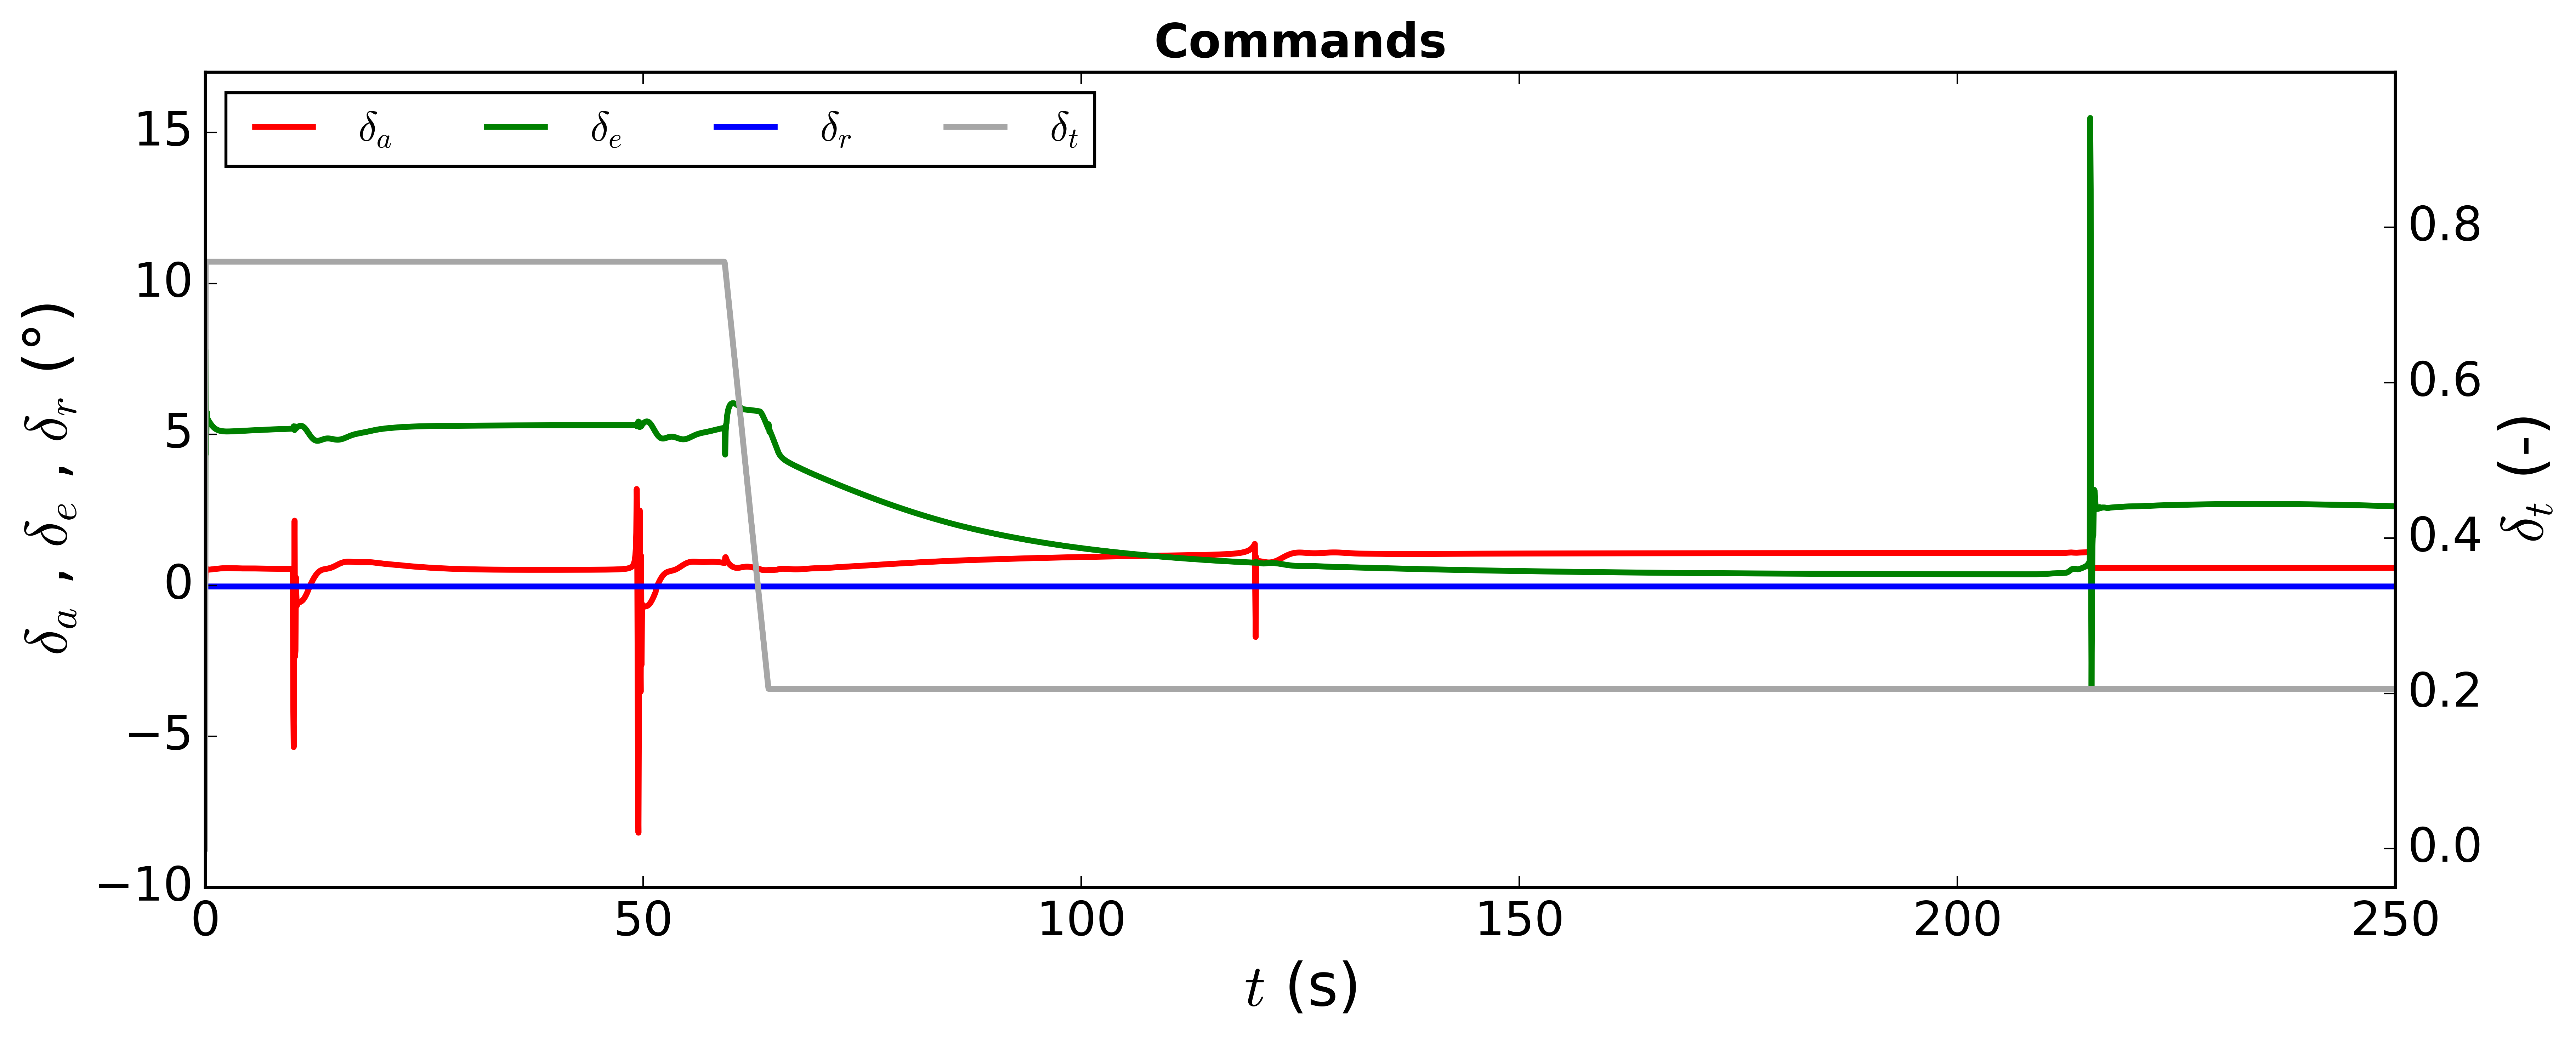

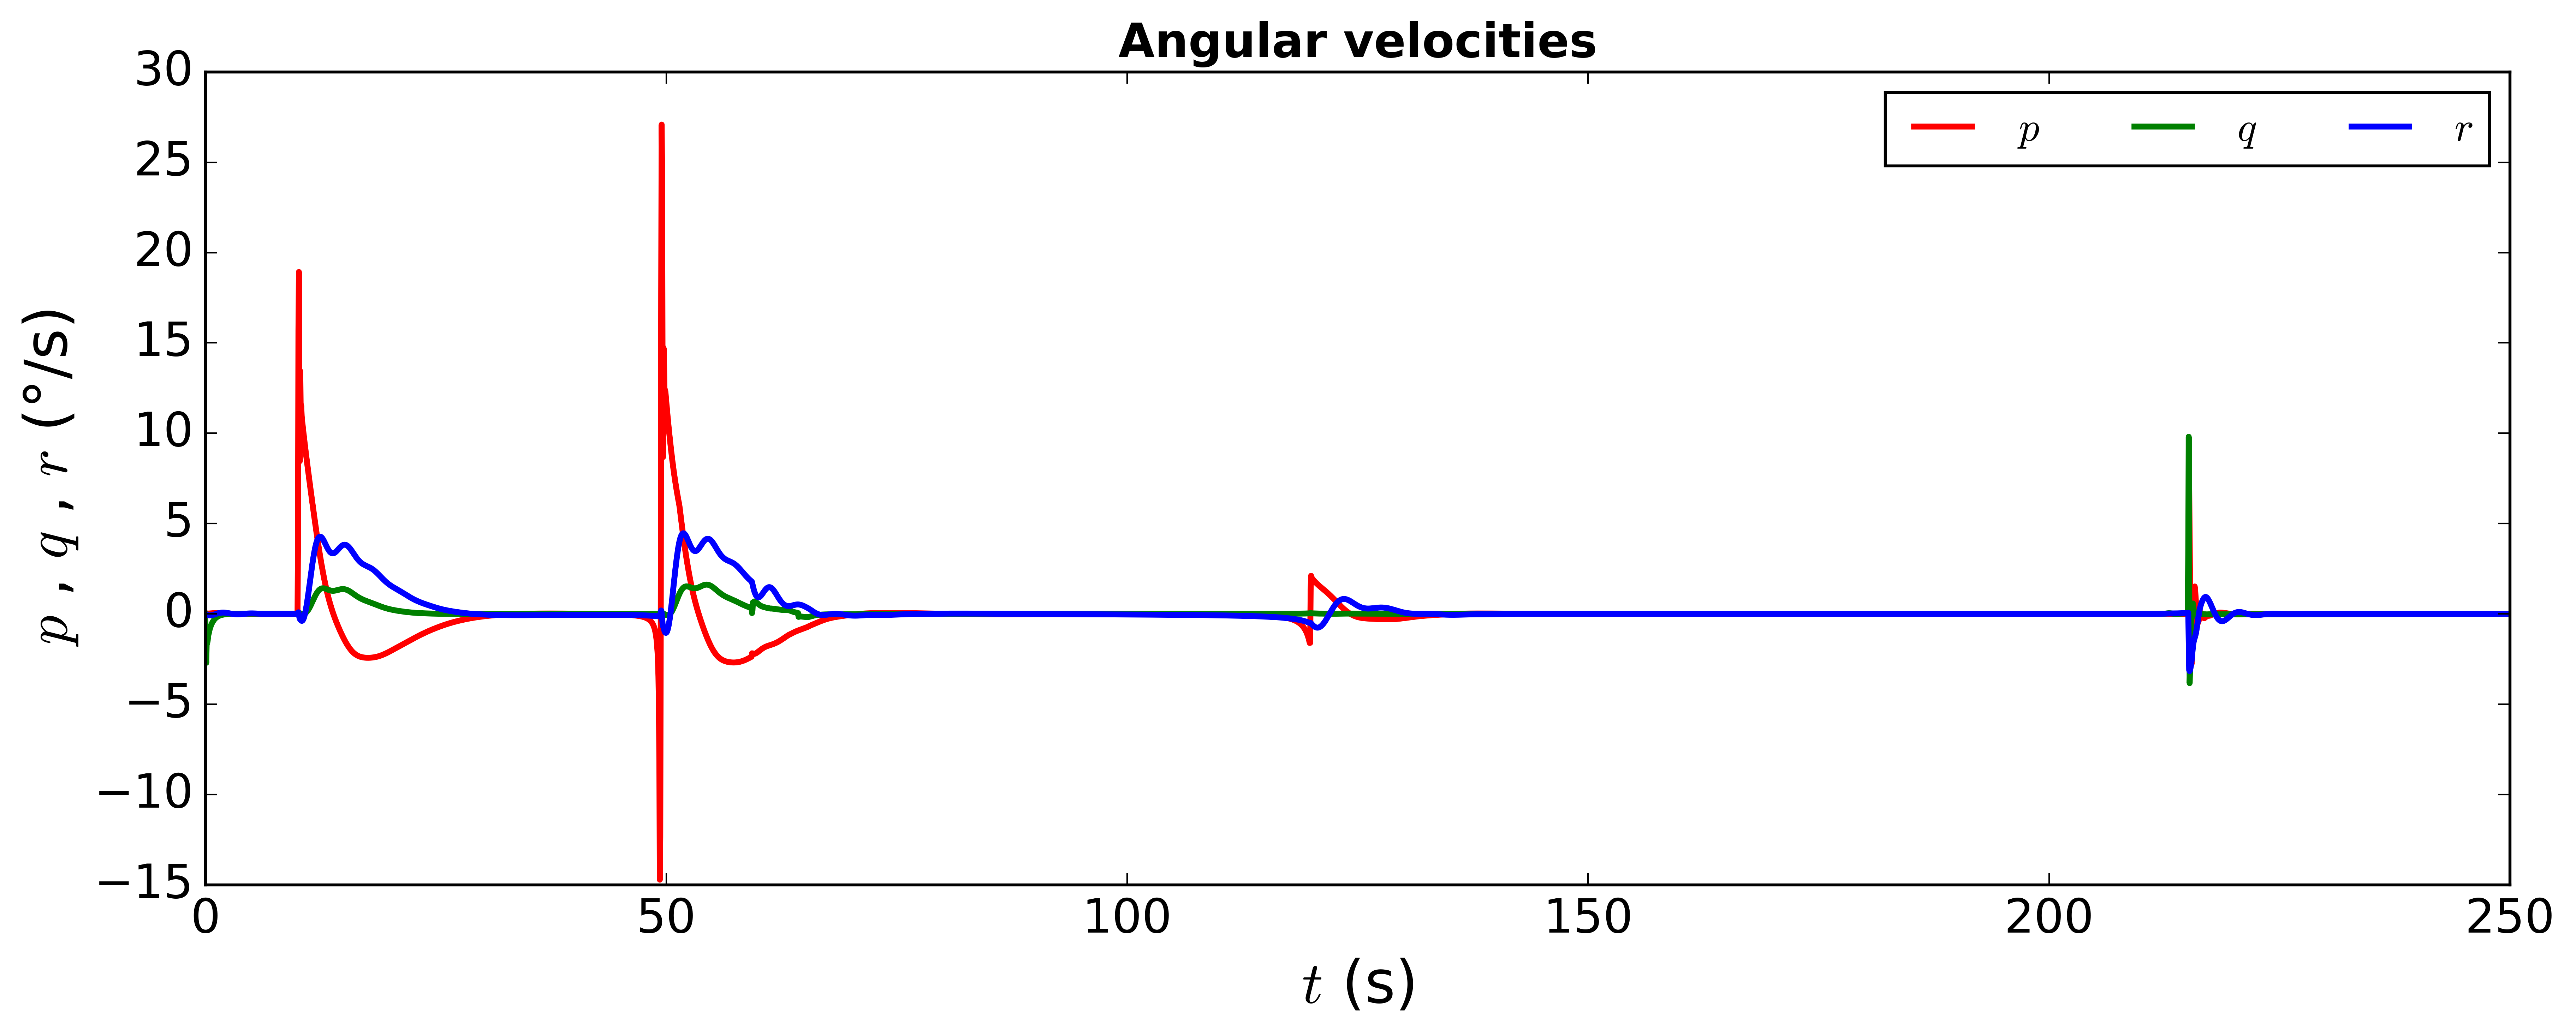

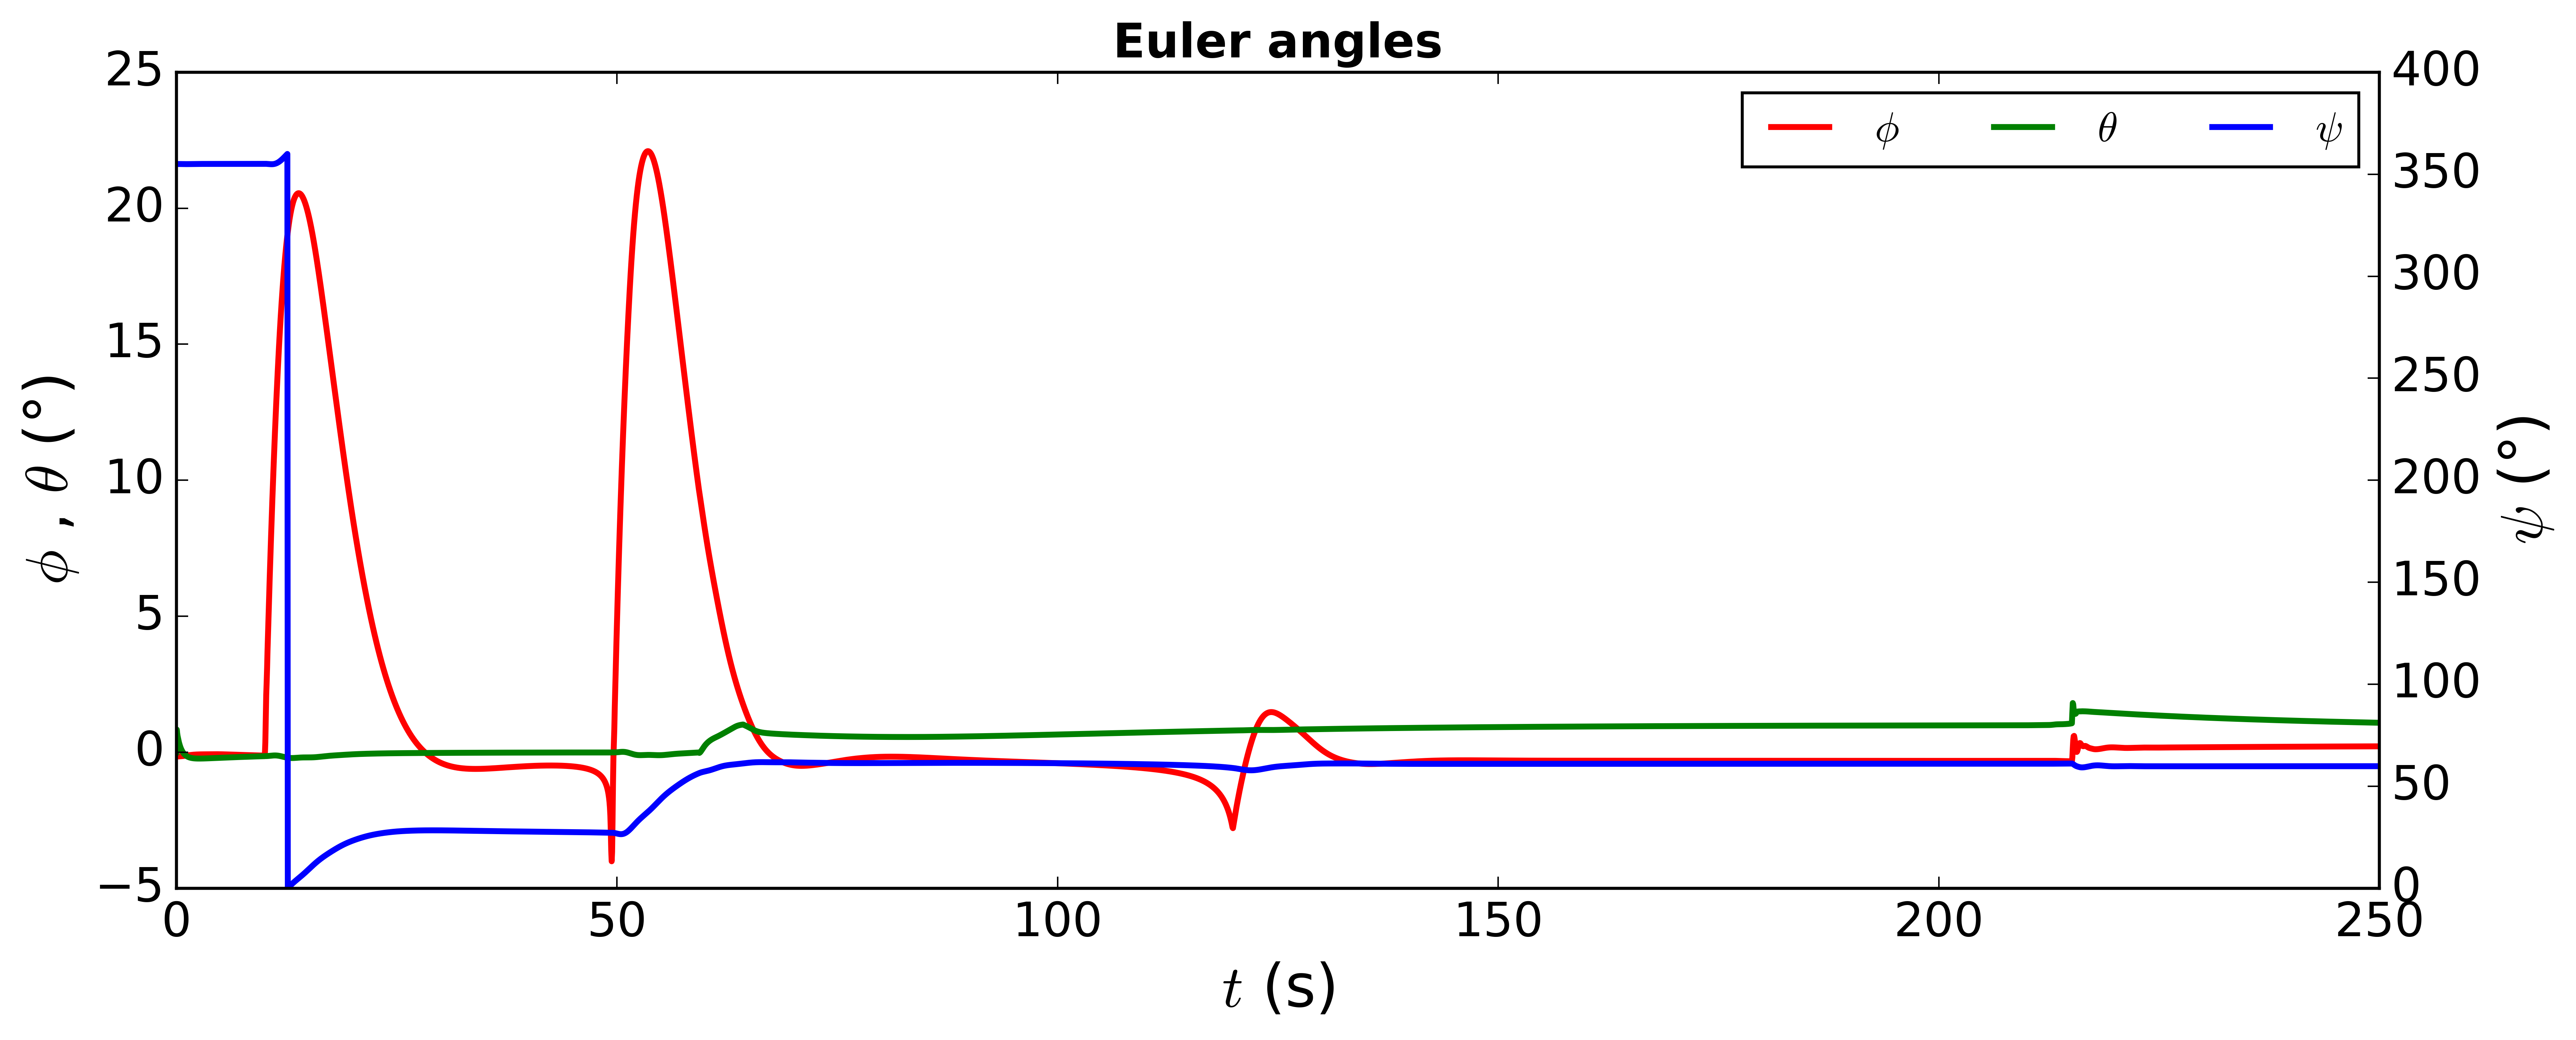

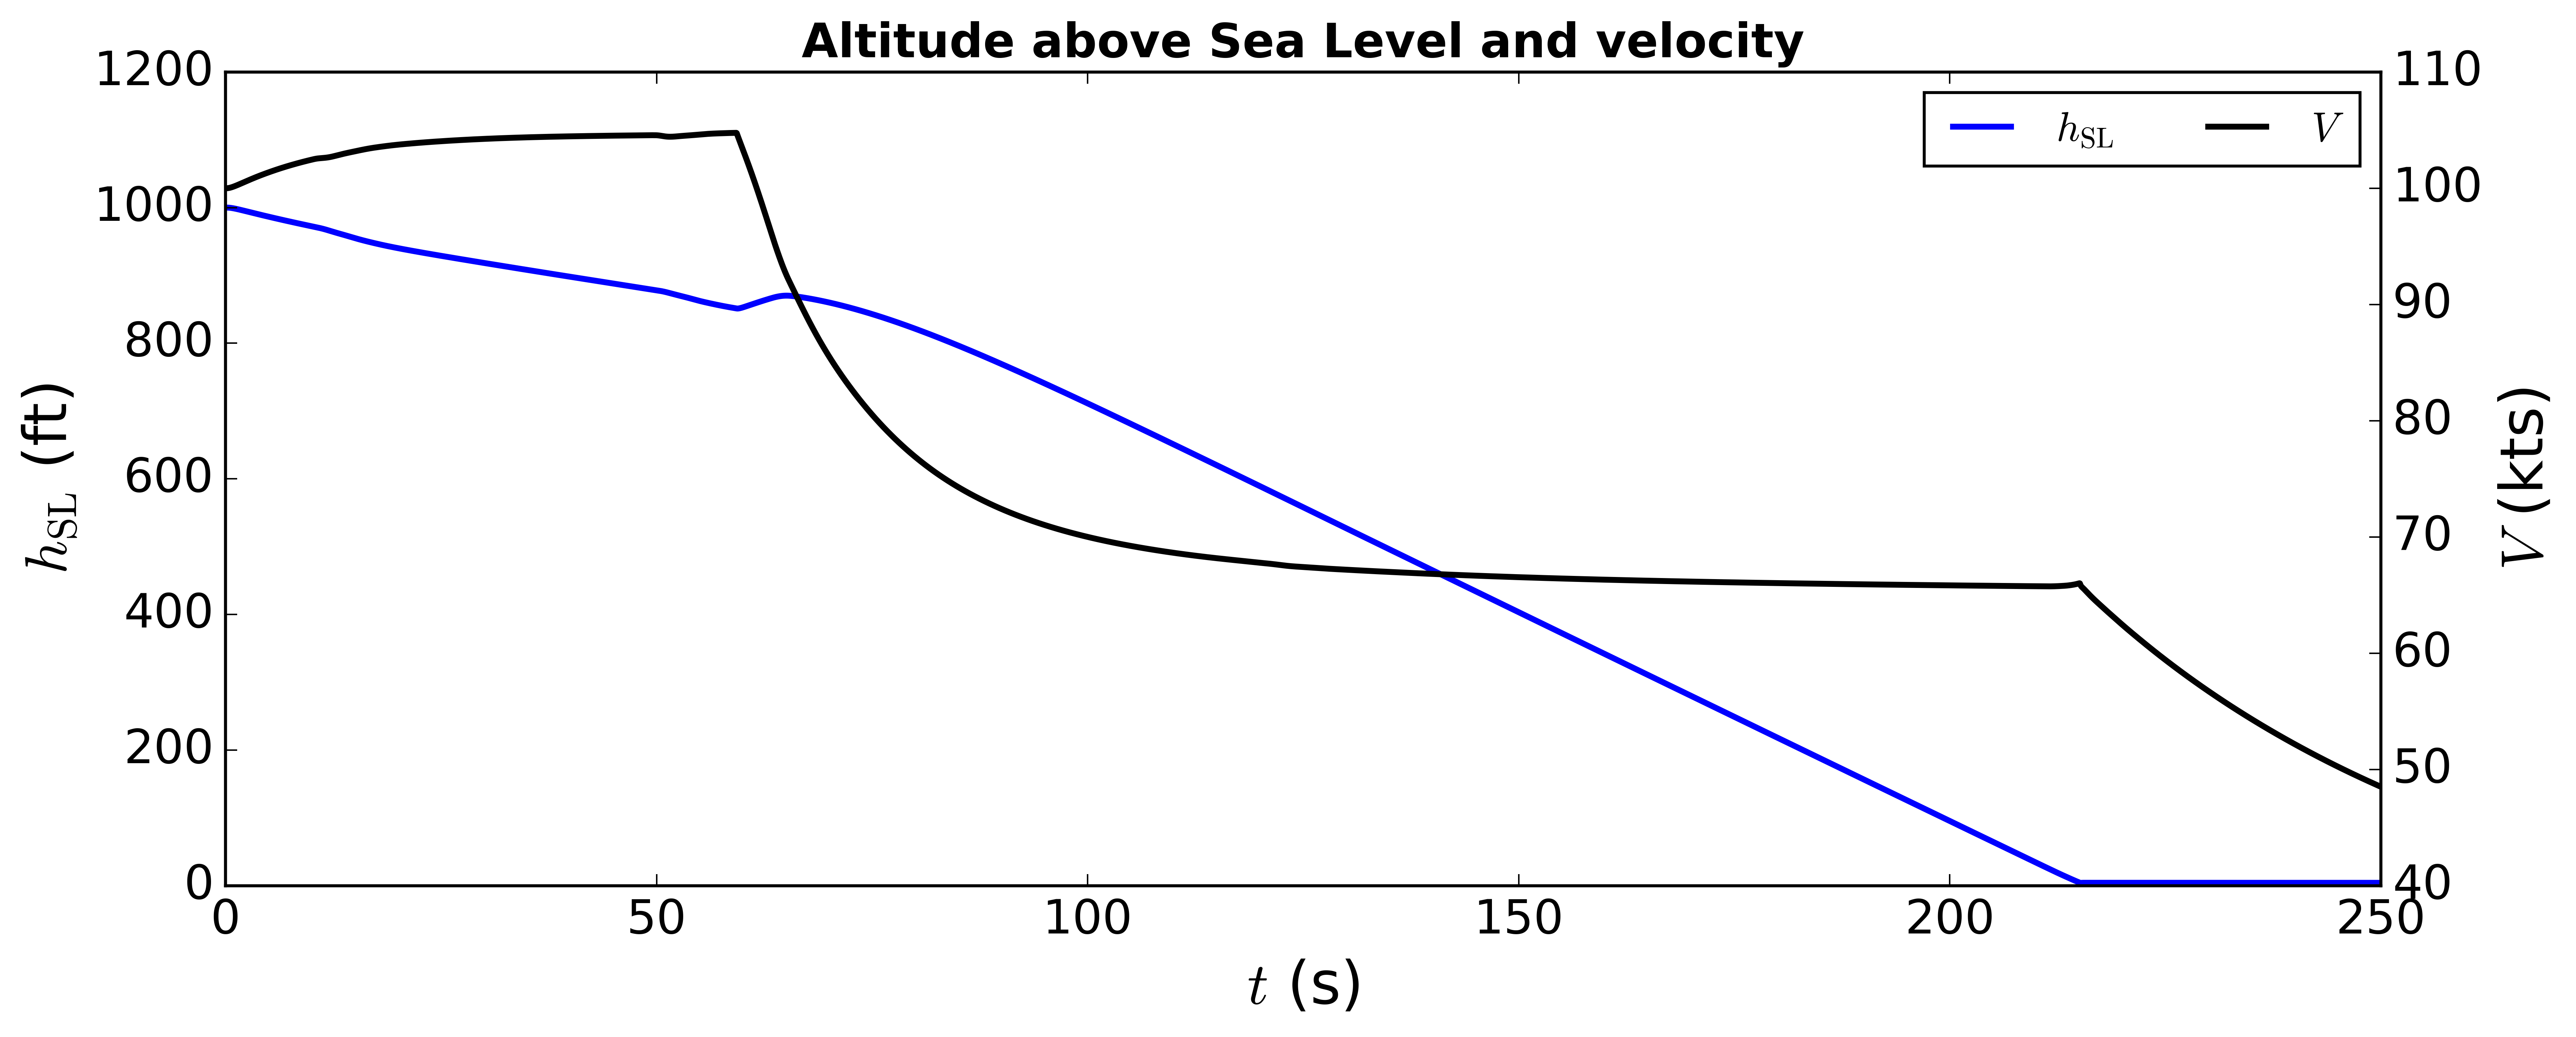

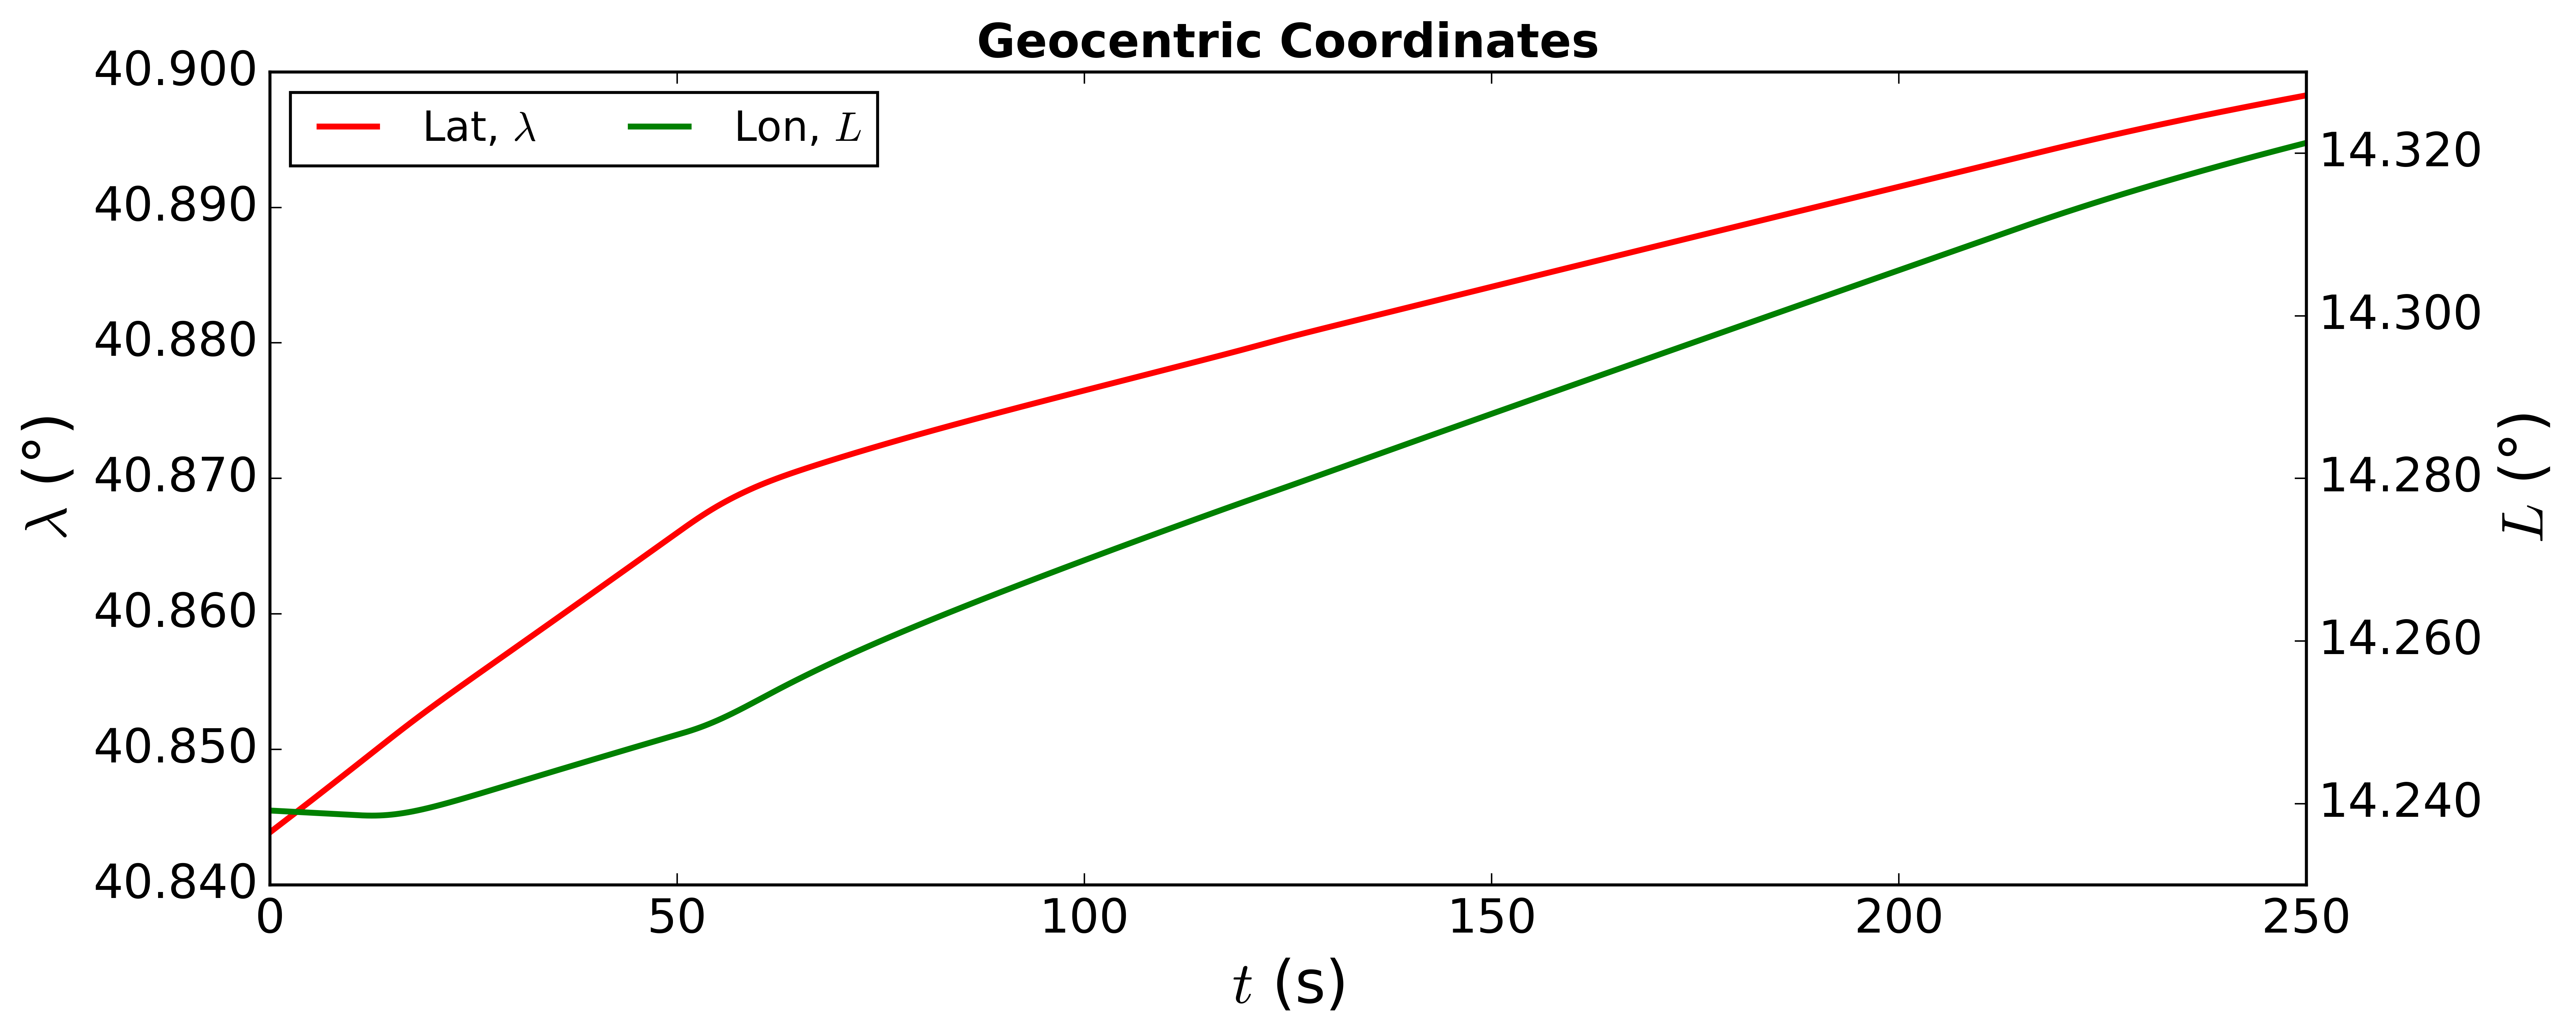

In [10]:
# JSBSim script launch command
os.system('../JSBSim/JSBSim --root=../JSBSim/ --script='+script_path+' > ../JSBSim/log_waypoint_auto_guidance.txt')

dh.move_files_to_folder('*.csv',dest_folder,'../JSBSim/')
dh.move_files_to_folder('*.txt',dest_folder,'../JSBSim/')

# Extract data arrays from output .csv files
sim = ACDataPlots('C172x_unina',dest_folder)

sim.plot_Commands()
sim.plot_AngularVel()
sim.plot_EulerAng()
sim.plot_AltitudeVelocity()
sim.plot_LatitLongit()

## Trajectory visualization

![](images/capture_path_Elmo2Capodichino06.png "Assigned path")

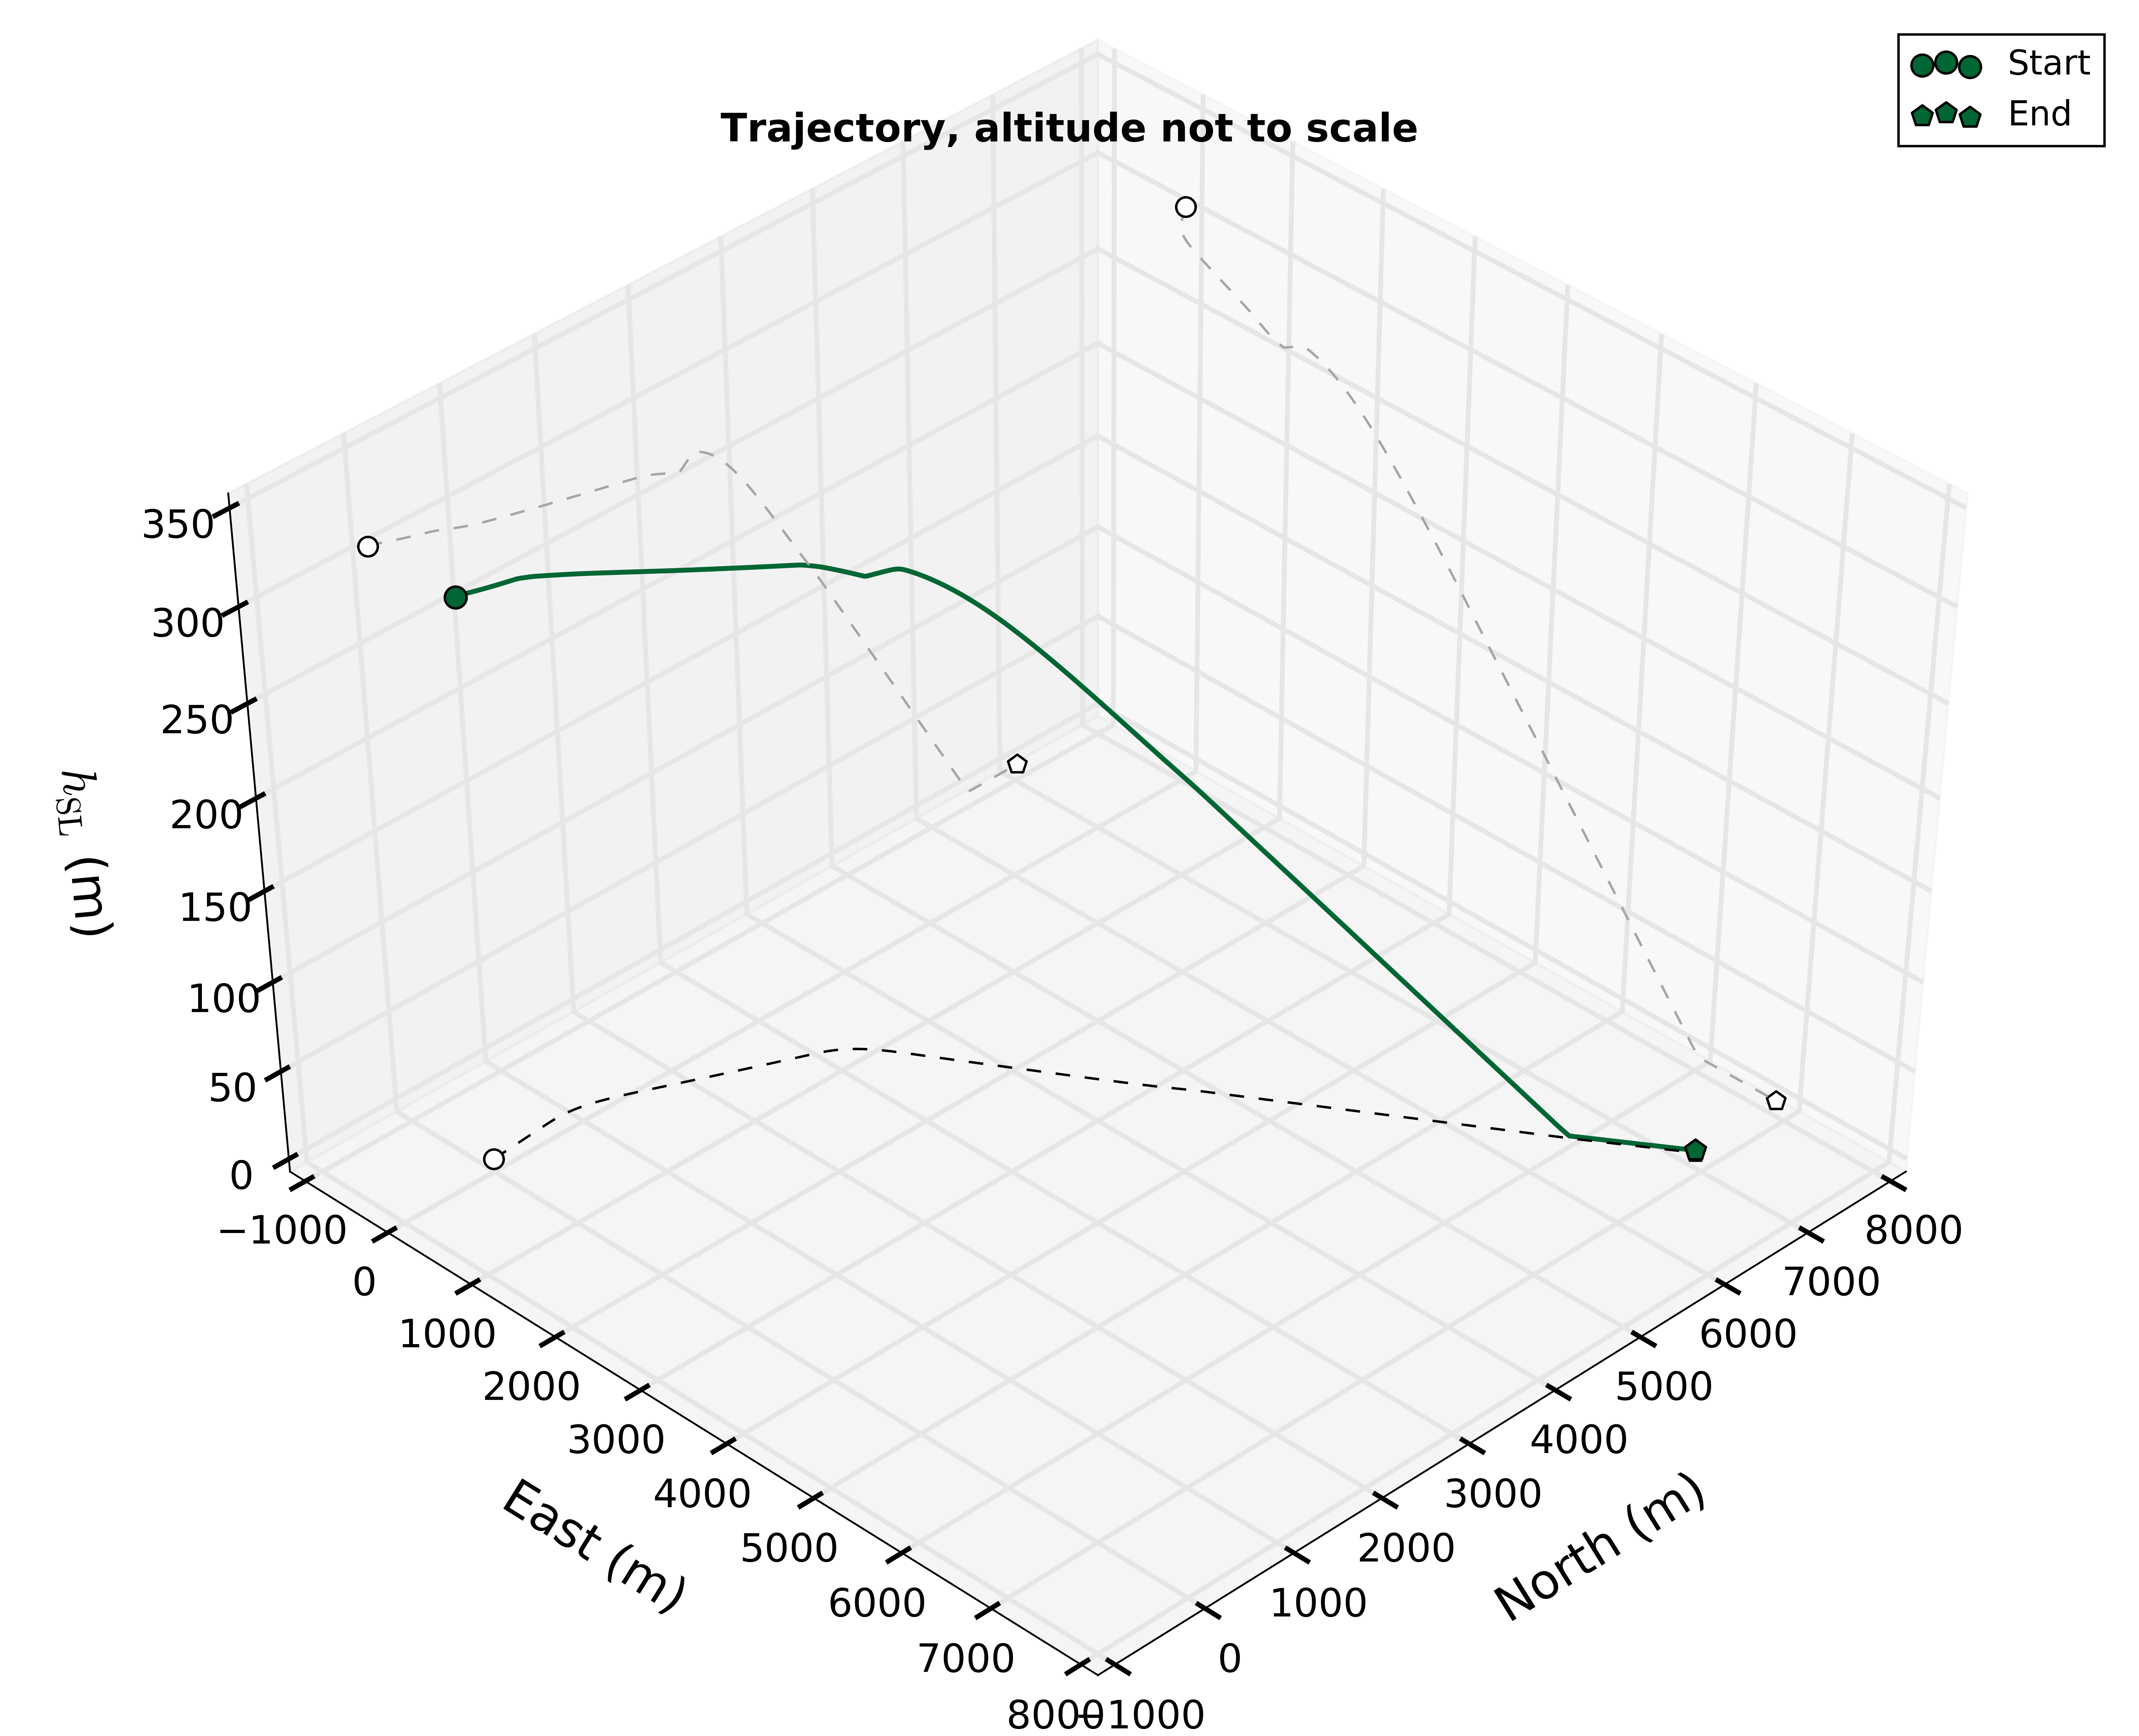

In [11]:
sim.get_traj_in_NEA()
sim.plot_GroundTrack('ft',arrow_size=2)
sim.plot_traj3D_in_NEA('m', X_proj='N', Y_proj='W', view=(45,45),to_scale='XY',)